# Preliminary study on VLLS and VLLD yields

I am considering the 2018 scenario with luminosity 59.8 fb$^{-1}$. I am investigating the singlet as well as the doublet models of VLL in purely electron like, and purely muon like scenarios. The following are the final states that I am interested in.
- 4L (inclusive)
- Exactly 3L
- Exactly 2L (OS and SS)
- Exactly 1L and XJ (X = 2+, 1, 0)
  
These final states are orthogonal to each other and the filling order does not matter.

### Object and event selections
I am picking medium ID electrons and muon as L with pT>10 and fabs(eta)<2.4 <br>
The Jets have pT>30 and abs(eta)<2.3 with standard selections.<br>
These reco objects are dR-cleaned by 0.5 from each other. The jets are also cleaned from standard taus.<br>
Here is a link to the details of object selections - https://github.com/phazarik/VLLSearch-Run3/blob/main/Setup/ProduceRecoCollection.h <br>
Here is a link to the details of event selections - https://github.com/phazarik/VLLSearch-Run3/blob/prachu_2LSS/Setup/EventSelection.h

### Trigger and cuts
The event should have at least one muon with pT>26 GeV, or one electron with pT>30 GeV. Right now I am not considering whether this lepton should be a part of the final state object or not (for channels containing more than one leptons). **There are no additional cuts right now.** Later, more cuts will be put on the individual channels to purify signals, which will bring down the acceptance and yield.

### Corrections for the doublet models
The VLLD models contain some <span style="color:red;">invalid</span> decay modes which are mentioned below.<br>
<div style="text-align:center;">
    $L\rightarrow W\nu_\tau$<br>
    $N\rightarrow H\nu_\tau, Z\nu_\tau$
</div>
We calculate acceptance by doing <code>nevt_in_channel/nevt_in_file</code>. However, in this case, the denomnator itself is reducing because of the event flag I used to get rid of these invalid decays. However, the effect on the numerator may not be the same. That's why I expect the numbers to be differnt from that of Yash. These is no such modification to the singlet models.

In [1]:
import ROOT
import os, sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

Welcome to JupyROOT 6.26/10


In [2]:
signal_file = 'signal_database.json'
with open(signal_file, 'r') as file: json_data = json.load(file)
print('Signal database loaded!')

datestamp = datetime.today().strftime('%Y-%m-%d')
plotdir = 'plots/'+datestamp
os.system(f'mkdir -p {plotdir}')
print('Plot directory ready!')

thin_line = {
    'marker':'o',
    'linestyle':'--',
    'markersize':3,
    'linewidth':1
}
thick_line = {
    'marker':'o',
    'linestyle':'-',
    'markersize':4,
    'linewidth':2
}

masses = [100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 600, 750, 800, 1000]

def accp(num, den):
    if den==0 : return 0
    else : return (num/den)*100

def lumiscale(lumi):
    datalumi = 59800
    scale = datalumi/lumi
    return scale

def put_text(ax):
    ax.text(0, 1.03, "CMS", transform=ax.transAxes, fontsize=12, fontweight='bold')
    ax.text(0.16, 1.03, "preliminary", transform=ax.transAxes, fontsize=12, fontstyle='italic')

Signal database loaded!
Plot directory ready!


#### Preparing the function to fillup a dictionary with acceptance and yields across the mass-points

In [3]:
def check_yields(model):
    plotdict = {
        '1L0J':{'color':'yellow',},
        '1L1J':{'color':'gold'},
        '1L2J':{'color':'orange'},
        '2LOS':{'color':'blue'},
        '2LSS':{'color':'cyan'},
        '3L'  :{'color':'green'},
        '4L'  :{'color':'red'}
    }

    print(f'Yield (acceptance %) for {model} :')
    print(f'mass\tnRAW\tn1L0J\t\tn1L1J\t\tn1L2J\t\tn2LOS\t\tn2LSS\t\tn3L\t\tn4L')
    
    for mass in masses:
        for key, val in json_data.items():
            if key == model:
                filename = f'../input_files/hst_{model}_M{str(mass)}.root'
                file_exists = os.path.exists(filename)
                
                if file_exists:
                    tfile = ROOT.TFile(filename)
                    hist = tfile.Get(f'finalstates_incldecay')
                    nall = hist.GetBinContent(1)
                    
                    print(f'\n{mass}\t{int(nall)}', end='\t')
                    
                    # For each final state:
                    for index, channel in enumerate(plotdict.keys()):
                        plotdict[channel][mass] = {}
                        
                        nchannel = hist.GetBinContent(index+2)
                        acceptance = accp(nchannel, nall)
                        masspoint = 'M' + str(mass)
                        lumi = json_data[model][masspoint].get("lumi", {})
                        scale = lumiscale(lumi)
                        nyield = int(nchannel * scale)
                        
                        # Putting these information in the dictionary: 
                        plotdict[channel][mass]['acceptance'] = acceptance
                        plotdict[channel][mass]['yield'] = nyield

                        #Printing out the numbers per channel:
                        print(f'{int(nyield)} ({acceptance:.1f}%)', end='\t')
                        
                        #break  # channelloop
                else :#If the file does not exists, delete the key
                    #print(f"{filename} not found ... removing mass {mass} from the dictionary" )
                    pass
                    
        #break  # Mass loop
    return plotdict
print('Dictionary maker ready!')

Dictionary maker ready!


#### Plotmaker:

In [4]:
def make_plot(model):
    plotdict_model = {}
    plotdict_model = check_yields(model)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(f'{model}', fontsize=16)  # Add a global title
    ax = ax.flatten()

    xaxis = list(plotdict_model['1L2J'].keys())[1:]
    combined_3L4L = [0]*len(xaxis)
    combined_all  = [0]*len(xaxis)
    
    for final_state, data in plotdict_model.items():
        color = data['color']  
        acceptances = [data[mass]['acceptance'] for mass in xaxis]
        ax[0].plot(xaxis, acceptances, label=final_state, color=color, **thin_line)
        combined_all = [sum(x) for x in zip(combined_all, acceptances)]
        if final_state in ['3L', '4L']: combined_3L4L = [sum(x) for x in zip(combined_3L4L, acceptances)]    
    ax[0].plot(xaxis, combined_3L4L, label=f'3L+4L', color='gray',  **thick_line)
    #ax[0].plot(xaxis, combined_all,  label=f'total', color='black', **thick_line)
    #ax[0].set_title(model+" accpetance", fontsize=14)
    ax[0].set_xlabel('Mass (GeV)', fontsize=12)
    ax[0].set_ylabel('Acc*eff (%)', fontsize=12)
    ax[0].set_ylim(0, 100)
    ax[0].set_xlim(0, 1200)
    ax[0].grid(True, alpha=0.5)
    ax[0].legend(loc='best', fontsize=8, ncol=2)
    put_text(ax[0])

    for final_state, data in plotdict_model.items():
        color = data['color']  
        yields = [data[mass]['yield'] for mass in xaxis]
        ax[1].plot(xaxis, yields, label=final_state, color=color, **thin_line)
    #ax[1].set_title(model+" yield", fontsize=14)
    ax[1].set_xlabel('Mass (GeV)', fontsize=12)
    ax[1].set_ylabel('Yield', fontsize=12)
    ax[1].set_xlim(0, 1200)
    ax[1].grid(True, alpha=0.5)
    ax[1].legend(loc='best', fontsize=8, ncol=2)
    put_text(ax[1])
    ax[1].text(0.62, 1.03, "(2018) 59.8 fb$^{-1}$", transform=ax[1].transAxes, fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'{plotdir}/yields_{model}.png', dpi=300)
    plt.show()

print('Plotmaker ready!')

Plotmaker ready!


### Plots for 4 types of models

Yield (acceptance %) for VLLS_ele :
mass	nRAW	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L

100	599740	21471 (3.6%)	35786 (6.0%)	35452 (5.9%)	16207 (2.7%)	826 (0.1%)	1771 (0.3%)	187 (0.0%)	
125	594714	17619 (3.0%)	36963 (6.2%)	68406 (11.5%)	39007 (6.6%)	3093 (0.5%)	7955 (1.3%)	2190 (0.4%)	
150	598626	19041 (3.2%)	46479 (7.8%)	113764 (19.0%)	61493 (10.3%)	4417 (0.7%)	10900 (1.8%)	3466 (0.6%)	
200	598182	16297 (2.7%)	47202 (7.9%)	159489 (26.7%)	85698 (14.3%)	5682 (0.9%)	13859 (2.3%)	5082 (0.8%)	
250	496991	11437 (2.3%)	35897 (7.2%)	151609 (30.5%)	82083 (16.5%)	5071 (1.0%)	12770 (2.6%)	5034 (1.0%)	
300	498516	9687 (1.9%)	32687 (6.6%)	163921 (32.9%)	89017 (17.9%)	5420 (1.1%)	13596 (2.7%)	5626 (1.1%)	
350	199194	3340 (1.7%)	11980 (6.0%)	68511 (34.4%)	37586 (18.9%)	2214 (1.1%)	5681 (2.9%)	2539 (1.3%)	
400	199048	3091 (1.6%)	11405 (5.7%)	70065 (35.2%)	38534 (19.4%)	2358 (1.2%)	5827 (2.9%)	2627 (1.3%)	
450	194893	2835 (1.5%)	10550 (5.4%)	70318 (36.1%)	39113 (20.1%)	2309 (1.2%)	5893 (3.0%)	2706 

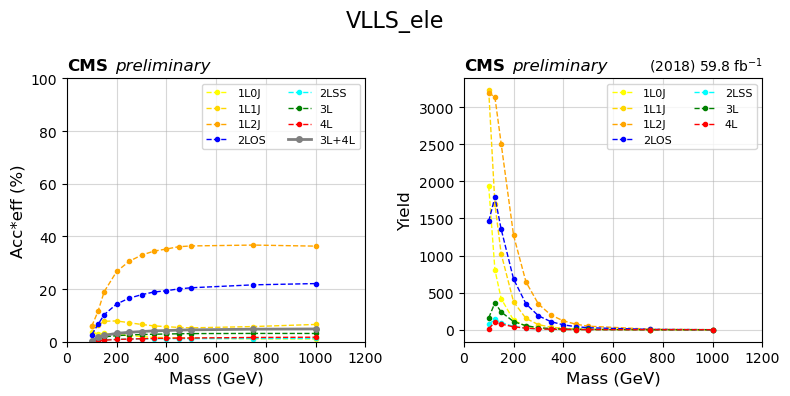

In [5]:
make_plot("VLLS_ele")

Yield (acceptance %) for VLLS_mu :
mass	nRAW	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L

100	594746	21036 (3.5%)	35584 (6.0%)	36249 (6.1%)	17124 (2.9%)	959 (0.2%)	2445 (0.4%)	365 (0.1%)	
125	599690	22180 (3.7%)	47461 (7.9%)	96532 (16.1%)	60122 (10.0%)	3794 (0.6%)	9961 (1.7%)	3617 (0.6%)	
150	598660	22317 (3.7%)	54154 (9.0%)	136608 (22.8%)	86714 (14.5%)	4383 (0.7%)	12917 (2.2%)	5431 (0.9%)	
200	599555	18150 (3.0%)	51110 (8.5%)	171035 (28.5%)	111924 (18.7%)	4976 (0.8%)	15314 (2.6%)	6926 (1.2%)	
250	496540	11966 (2.4%)	37200 (7.5%)	155632 (31.3%)	103628 (20.9%)	4179 (0.8%)	14036 (2.8%)	6499 (1.3%)	
300	499438	9838 (2.0%)	33260 (6.7%)	166056 (33.2%)	110022 (22.0%)	4312 (0.9%)	14559 (2.9%)	7206 (1.4%)	
400	198686	3212 (1.6%)	11277 (5.7%)	69652 (35.1%)	46628 (23.5%)	1676 (0.8%)	6250 (3.1%)	3260 (1.6%)	
450	197673	2908 (1.5%)	10895 (5.5%)	70745 (35.8%)	46888 (23.7%)	1612 (0.8%)	6141 (3.1%)	3311 (1.7%)	
500	199603	2758 (1.4%)	10580 (5.3%)	71678 (35.9%)	48406 (24.3%)	1622 (0.8%)	6426 (3.2%)	34

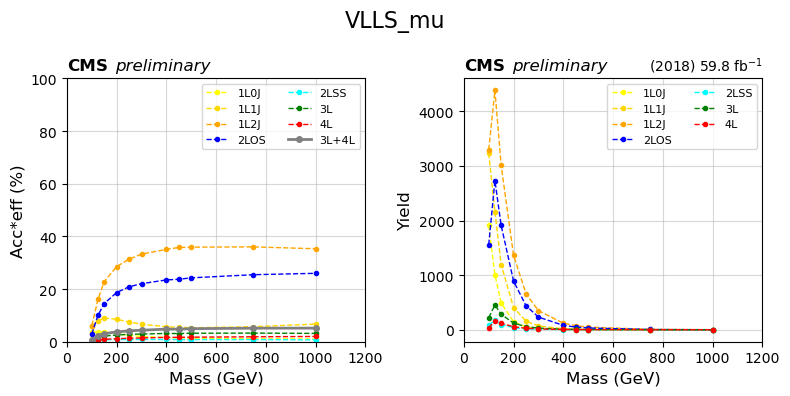

In [6]:
make_plot("VLLS_mu")

Yield (acceptance %) for VLLD_ele :
mass	nRAW	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L

100	110871	1947 (1.8%)	3493 (3.2%)	6627 (6.0%)	8248 (7.4%)	3054 (2.8%)	3682 (3.3%)	521 (0.5%)	
200	73730	985 (1.3%)	3351 (4.5%)	17285 (23.4%)	27940 (37.9%)	3146 (4.3%)	7817 (10.6%)	1623 (2.2%)	
300	24753	155 (0.6%)	699 (2.8%)	5733 (23.2%)	11022 (44.5%)	1039 (4.2%)	3183 (12.9%)	725 (2.9%)	
400	24491	91 (0.4%)	434 (1.8%)	5458 (22.3%)	11732 (47.9%)	1068 (4.4%)	3318 (13.5%)	789 (3.2%)	
600	24611	104 (0.4%)	439 (1.8%)	5565 (22.6%)	11589 (47.1%)	1094 (4.4%)	3452 (14.0%)	749 (3.0%)	
800	23680	39 (0.2%)	284 (1.2%)	4571 (19.3%)	12046 (50.9%)	1076 (4.5%)	3754 (15.9%)	847 (3.6%)	
1000	24286	3 (0.0%)	56 (0.2%)	4992 (20.6%)	12680 (52.2%)	1124 (4.6%)	3856 (15.9%)	973 (4.0%)	

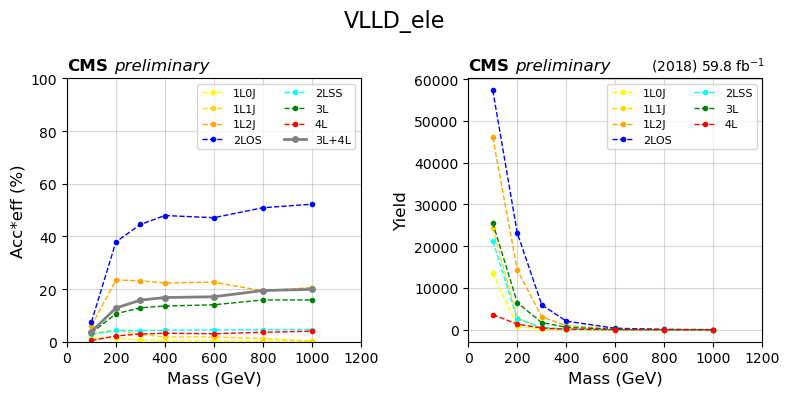

In [7]:
make_plot("VLLD_ele")

Yield (acceptance %) for VLLD_mu :
mass	nRAW	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L

100	111926	2155 (1.9%)	4253 (3.8%)	10133 (9.1%)	15805 (14.1%)	3109 (2.8%)	7312 (6.5%)	1003 (0.9%)	
200	73908	980 (1.3%)	2775 (3.8%)	10781 (14.6%)	38989 (52.8%)	1794 (2.4%)	10450 (14.1%)	2319 (3.1%)	
300	25022	142 (0.6%)	513 (2.1%)	3315 (13.2%)	14283 (57.1%)	543 (2.2%)	3992 (16.0%)	923 (3.7%)	
400	24299	71 (0.3%)	306 (1.3%)	2822 (11.6%)	14431 (59.4%)	498 (2.1%)	4154 (17.1%)	955 (3.9%)	
600	24890	38 (0.2%)	219 (0.9%)	2630 (10.6%)	15090 (60.6%)	461 (1.9%)	4506 (18.1%)	1021 (4.1%)	
800	24763	31 (0.1%)	211 (0.9%)	2402 (9.7%)	15210 (61.4%)	439 (1.8%)	4459 (18.0%)	1145 (4.6%)	

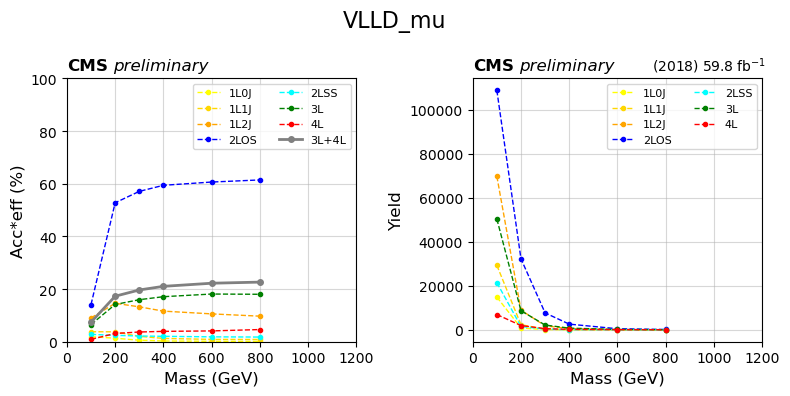

In [8]:
make_plot("VLLD_mu")